# Capstone EDA - FEMA Data

Before we could do too much Exploratory Data Analysis, we needed to upload our data--both in full and in the aggregate:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as stats

In [2]:
# After executing the "Wrangling" code for my capstone, the following df will be stored locally as 'FEMA.csv'
file = "FEMA.csv"
dates = ['declarationDate','incidentBeginDate','incidentEndDate','disasterCloseOutDate']

df = pd.read_csv(file, sep = '\t', index_col = ['disasterNumber', 'zipCode', 'city'], parse_dates = dates, low_memory = False)

In [3]:
# The aggregate df (agg_df) is also saved and will be needed for this EDA

file_2 = "aggregate_FEMA.csv"

agg_df = pd.read_csv(file_2, sep = '\t', index_col = ['disasterNumber'], parse_dates = dates, low_memory = False)

I'll want to explore the idea of "spread" of particular disasters, so we'll create a predictor: 'zip_counts', the sum of all zipcodes associated with each respective disaster.

In [4]:
dn_list = agg_df.index
zip_counts = []

for dn in dn_list:
    a = df.reset_index().set_index('disasterNumber').loc[dn,:]
    count = len(pd.Series(a.zipCode).unique())
    zip_counts.append(count)

In [6]:
# this is our measure of "spread" for any one disaster--how many zip codes did it cover

agg_df['zip_counts'] = zip_counts

While we don't have a statistical analysis to follow it, as further preparation for diving into our data, I want to look into at least some example data of the 3 measures of 'effected individual count': 'Valid Registrations, 'Total Inspected', and 'Approved for FEMA Assistance'.

In [105]:
agg_df.loc[:,['zip_counts','validRegistrations','totalInspected','approvedForFemaAssistance']].sort_values('zip_counts', ascending = False).head()

,zip_counts,validRegistrations,totalInspected,approvedForFemaAssistance
disasterNumber,,,,
4337,1773,2636237.0,1001211.0,777198.0
1557,1147,33861.0,31086.0,25009.0
1545,1076,243046.0,316714.0,226457.0
4339,986,1116419.0,753717.0,464570.0
4020,949,42969.0,35215.0,22892.0


While still considering my options, I asked whether we might find patterns/trends by subsetting for each disaster type. Though this proved fruitless, the code is below:

In [8]:
# can we use a for loop to create subplots for each incident type?

# step one: slice agg_df by 'incidentType'
incident_list = agg_df.incidentType.unique()

inc_df_list = []
for inc in incident_list:
    inc_df = agg_df[agg_df['incidentType']==inc]
    inc_df_list.append(inc_df)

In [9]:
for incident, df in zip(incident_list, inc_df_list):
    print(str(incident) + ", disaster count : " + str(df.shape[0]))

Hurricane, disaster count : 62
Typhoon, disaster count : 5
Severe Storm(s), disaster count : 177
Tornado, disaster count : 9
Fire, disaster count : 14
Earthquake, disaster count : 4
Flood, disaster count : 32
Other, disaster count : 1
Mud/Landslide, disaster count : 1
Volcano, disaster count : 1


In [10]:
# what about when certain programs are inacted?
program_list = ['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']

p_df_list = []
for program in program_list:
    p_df = agg_df[agg_df[program]==1]
    p_df_list.append(p_df)

In [11]:
for program, df in zip(program_list, p_df_list):
    print(str(program) + ", disaster count : " + str(df.shape[0]))

ihProgramDeclared, disaster count : 218
iaProgramDeclared, disaster count : 94
paProgramDeclared, disaster count : 254
hmProgramDeclared, disaster count : 302


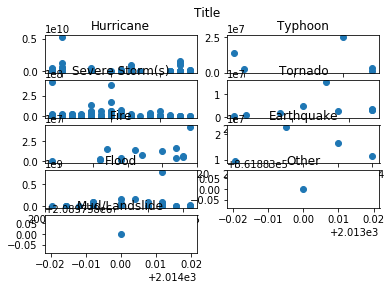

In [30]:
x = 'fyDeclared'
y = 'totalApprovedIhpAmount'

a, b = inc_df_list, incident_list

for i, j, k in zip(range(1, len(a)), a, b):
    plt.subplot(5, 2, i)
    plt.scatter(x = x, y = y, data = j)
    plt.title(b[i-1])

plt.suptitle('Title')
plt.show()

These plots could be cleaned, up, but I don't think we're finding anything exceptional here in this data. Again, it proved fruitless, but it was worth considering. Now to move on to the actual EDA prompts.

#### Are there variables that are particularly significant in terms of explaining the answer to your project question?

My three initiatives at the start were to:

1) assess FEMA’s mitigation protocols based on money spent over time
2) rate regions (zipcode or county) for mitigation priority
3) predict disasters to assist mitigation efforts and save money

To the first end, we have a few metrics for "money spent":
    'Total Approved IHP Amount', and then the components of that amount, 'Repair Replace Amount', 'Rental Amount', and 'Other Needs Amount'. We can also look at financial grants which were approved with each disaster. These are subsetted into 4 ranges: '1 - 10,000 dollars', '10,001 - 25,000 dollars', '25,001 dollars - Max Grant', and 'Max Grants'. These grants should tell us a bit about the severity of damage, since we can intuit that FEMA has designated these ranges for a reason, i.e. the worst disasters will warrant/have warranted the distribution of $30,000+ grants, but many home owners/renters benefit from these other particular levels. As for the x-axis, we have the fiscal year each disaster was declared.

To the second end, we would need to reindex and then aggregate our information (critically, whatever our 'money spent' metric is) by zip code and by year.
    
This final initiative is our most ambitious one because predicting disasters in general is a tall (nigh impossible) task, but to do it with our limited data (which is mostly financial) makes it much taller a task. 


#### Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?

In [82]:
# important columns for checking correlation

corr_cols = agg_df.reset_index()[['disasterNumber','title','incidentType','fyDeclared','disasterLength','zip_counts',
                                  'totalApprovedIhpAmount','approvedForFemaAssistance']]

# last bit of data wrangling that needs to be done (unescapable)

corr_cols['disasterLength'] = corr_cols['disasterLength'].str.split(expand = True)
corr_cols['disasterLength'] = pd.to_numeric(corr_cols['disasterLength'], errors = 'coerce')

corr_cols = corr_cols.rename(columns = {'disasterLength':'length',
                                        'totalApprovedIhpAmount':'apprAmount',
                                        'approvedForFemaAssistance':'apprIndv'})

corr_cols = corr_cols.set_index('disasterNumber')

In [84]:
corr_cols.sort_values('zip_counts', ascending = False).head()

,title,incidentType,fyDeclared,length,zip_counts,apprAmount,apprIndv
disasterNumber,,,,,,,
4337,HURRICANE IRMA,Hurricane,2017,44.0,1773,1.020335e+09,777198.0
1557,TROPICAL DEPRESSION IVAN,Hurricane,2004,14.0,1147,8.654718e+07,25009.0
1545,HURRICANE FRANCES,Hurricane,2004,34.0,1076,4.097340e+08,226457.0
4339,HURRICANE MARIA,Hurricane,2017,59.0,986,1.244248e+09,464570.0
4020,HURRICANE IRENE,Hurricane,2011,10.0,949,1.028656e+08,22892.0


First, we need to establish a null hypothesis: what are we asking; what are the assumed relationships? Let's begin our inquiry by examing the correlation table with each of our important variables:

In [85]:
corr_cols[2:].corr()

,fyDeclared,length,zip_counts,apprAmount,apprIndv
fyDeclared,1.000000,-0.059470,-0.040830,-0.025271,-0.002058
length,-0.059470,1.000000,0.208285,0.119449,0.125618
zip_counts,-0.040830,0.208285,1.000000,0.445605,0.664998
apprAmount,-0.025271,0.119449,0.445605,1.000000,0.828424
apprIndv,-0.002058,0.125618,0.664998,0.828424,1.000000


    Right away, we see that nothing about these disasters is correlated in any way with time (as we should expect), so we can write that off. Interestingly, the length of the disaster also shows weak correlations with things like cost and spread ('apprAmount' and 'zip_counts', respectively). Length here is a function of end date and start date--does this weak correlation correspond with limited initiative on FEMA's part end a disaster as quickly as possible? In essence, because their payout is potentially 'uneffected' by how long it takes a disaster to end, what is FEMA's motivation to reach a conclusion?
    
Ho: shorter disasters and longer disasters cost FEMA the same amount.
Ha: shorter disasters and longer disasters do not cost FEMA the same.


In [92]:
corr_cols['length'].describe()

count    305.000000
mean      21.691803
std       28.121858
min       -1.000000
25%        4.000000
50%       12.000000
75%       29.000000
max      168.000000
Name: length, dtype: float64

In [103]:
median = 12

# median disaster length is 12 days, so we can divide disasters in short and long around 12

short = corr_cols[corr_cols['length'] <= median]
long = corr_cols[corr_cols['length'] > median]

s_count = short.shape[0]
l_count = long.shape[0]

print("Number of short disasters : ", s_count)
print("Number of long disasters : ", l_count)

Number of short disasters :  158
Number of long disasters :  147


What are the most appropriate tests to use to analyse these relationships?

#### We will use a t-test to evaluate the hypothesis with a significance (a) of 0.05.

In [101]:
from scipy import stats
T, p = stats.ttest_ind(short['apprAmount'],
                       long['apprAmount'],
                       equal_var = False)

print('Test Statistic (T) : ', T)
print('p-value : ', p)

Test Statistic (T) :  -2.2405555891802265
p-value :  0.027181672426063935


With a p-value of 0.0148, we reject our null hypothesis short and long disasters cost FEMA the same amount. However, it's important to realize that with a lower alpha (e.g. 0.01) we should have failed to reject. With this knowledge, we need further insights--perhaps an industry specific understanding of disaster recovery methods.

Perhaps we chose our division of lengths too arbitrarily. It should be noted that if we designate 'short disasters' as those lasting two weeks or less and 'long disasters' as lasting three weeks or more, the p-value is still only 0.027--still failing to reject the null.

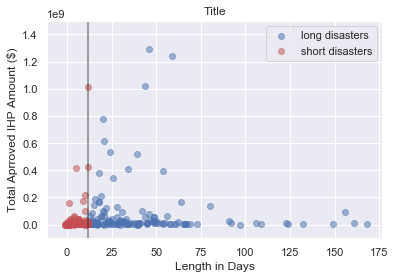

In [111]:
import seaborn as sns

sns.set()
plt.scatter(long['length'], long['apprAmount'], c='b', label="long disasters", alpha=0.5)

plt.scatter(short['length'], short['apprAmount'], c='r', label="short disasters", alpha=0.5)
plt.axvline(x = 12, color = 'k', alpha = 0.5)


#plt.xlim([-100,4000])
plt.ylim([-0.1e9,1.5e9])
plt.xlabel('Length in Days')
plt.ylabel('Total Aprroved IHP Amount ($)')
plt.title('Title')
plt.legend()

Our plot confirms our statistical analysis, but also gives us some insight into how the numbers cam out the way they did. Our exceptionally long disasters (4 months+) seem to pull the average down for amount approved for our longer disasters.